# Historical functional linear model

In [1]:
import numpy as np
import pickle
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
import scipy
from tqdm.notebook import tqdm
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.representation.basis import Fourier, FDataBasis
from skfda.representation.grid import FDataGrid

import matplotlib.pyplot as plt

### Generating functional data

In [2]:
# define meshes
def sample_points(n_samples, n_obs, uniform_samp=True, random_state=None):
    """
    Randomly samples the observation points for each function sample
    
    Inputs:
    n_samples: number of function samples
    n_obs: number of observations per function sample
    uniform_samp: parameter to decide which random point sampling procedure to use for each function sample
                     True is random uniform sampling on [0,1] 
                     False is random sampling using the density p(t) = 0.8 + 0.4*t on [0,1]
    random_state: random seed
    
    Returns:
    obs_points: observation point locations for each random function
    
    """
    rng = np.random.RandomState(random_state)
    if n_samples > 1:
        obs_grid = rng.uniform(0, 1, (n_samples,n_obs))
    else:
        obs_grid = rng.uniform(0, 1, (n_samples,n_obs))
    
    if uniform_samp:
        obs_grid.sort(axis=1)
        return obs_grid
    else:
        obs_grid = np.sqrt(4 + 5*obs_grid) - 2
        obs_grid.sort(axis=1)
        return obs_grid

In [3]:
# generate Pomann data
def gen_data_normal(n_samples, obs_points, sd=np.sqrt(0.25), random_state=None):
    """
    Coefficients of Fourier basis functions are drawn from normal distribution
    Inputs:
    n_samples: number of function samples
    n_obs: observation points
    sd: the standard deviation of the observation noise
    """
    rng = np.random.RandomState(random_state)
    n_points = obs_points.shape[1]
    X = rng.normal(0, np.sqrt(10), (n_samples,1)) * np.sqrt(2) * np.sin(2*np.pi*obs_points) + rng.normal(0, np.sqrt(5), (n_samples,1)) * np.sqrt(2) * np.cos(2*np.pi*obs_points)
    X += obs_points    # adding mean function
    X += rng.normal(0, sd, (n_samples,n_points))    # adding noise epsilon
    return X


def gen_data_uniform(n_samples, obs_points, sd=np.sqrt(0.25), random_state=None):
    """
    Coefficients of Fourier basis functions are drawn from uniform distribution
    Inputs:
    n_samples: number of function samples
    obs_points: observation points
    sd: the standard deviation of the observation noise
    """
    rng = np.random.RandomState(random_state)
    n_points = obs_points.shape[1]
    X = rng.uniform(-10, 10, (n_samples,1)) * np.sqrt(2) * np.sin(2*np.pi*obs_points) + rng.uniform(-5, 5, (n_samples,1)) * np.sqrt(2) * np.cos(2*np.pi*obs_points)
    X += obs_points    # adding mean function
    X += rng.normal(0, sd, (n_samples,n_points))    # adding noise epsilon
    return X


def gen_data_exp(n_samples, obs_points, sd=np.sqrt(0.25), random_state=None):
    """
    Coefficients of Fourier basis functions are drawn from exponential distribution
    Inputs:
    n_samples: number of function samples
    obs_points: observation points
    sd: the standard deviation of the observation noise
    """
    rng = np.random.RandomState(random_state)
    n_points = obs_points.shape[1]
    X = rng.exponential(1.5, (n_samples,1)) * np.sqrt(2) * np.sin(2*np.pi*obs_points) + rng.exponential(3, (n_samples,1)) * np.sqrt(2) * np.cos(2*np.pi*obs_points)
    X += obs_points    # adding mean function
    X += rng.normal(0, sd, (n_samples,n_points))    # adding noise epsilon
    return X


def gen_data_t(n_samples, obs_points, sd=np.sqrt(0.25), random_state=None):
    """
    Coefficients of Fourier basis functions are drawn from standard student-t distribution
    Inputs:
    n_samples: number of function samples
    obs_points: observation points
    sd: the standard deviation of the observation noise
    """
    rng = np.random.RandomState(random_state)
    n_points = obs_points.shape[1]
    X = rng.standard_t(3, (n_samples,1)) * np.sqrt(2) * np.sin(2*np.pi*obs_points) + rng.standard_t(5, (n_samples,1)) * np.sqrt(2) * np.cos(2*np.pi*obs_points)
    X += obs_points    # adding mean function
    X += rng.normal(0, sd, (n_samples,n_points))    # adding noise epsilon
    return X

In [4]:
# using skfda to generate Ramsay data
def skfda_basis(n_samples, upper_limit=2*np.pi, n_basis=3, sd=1):
    basis = Fourier((0, upper_limit), n_basis=n_basis)
    coefficients = np.random.normal(0, sd, size=(n_samples, n_basis))
    X_fd = FDataBasis(basis, coefficients)
    return X_fd

### Interpolation of random data

In [5]:
# interpolation with Gaussian processes
def GPR_single_sample(X, obs_points, pred_points, nu=2.5, gp_alpha=1e-1):
    """
    Given a single sample of functional data X at locations obs_points, a GP is fit and mean predictions are
    given at locations pred_points
    
    Inputs:
    X: single function sample
    obs_points: function sample observation locations
    pred_points: prediction locations
    nu: Matern kernel smoothness parameter
    gp_alpha: smoothness penalty
    
    Returns:
    The predictions of a Matern GP with parameters nu and alpha, at locations pred_points
    """
    kernel = gp.kernels.Matern(nu=nu)
    GP = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=4, alpha=gp_alpha)
    GP.fit(obs_points, X)
    return GP.predict(pred_points)

def GPR_multi_sample(X, obs_points, pred_points, nu=2.5, gp_alpha=1e-1):
    """
    Given multiple samples of functional data X, an array of corresponding observation locations obs_points, 
    a GP is fit and mean predictions are given at locations pred_points
    
    Inputs:
    X: multiple function samples
    obs_points: function samples observation locations
    pred_points: prediction locations
    nu: Matern kernel smoothness parameter
    gp_alpha: smoothness penalty
    
    Returns:
    The predictions of a Matern GP with parameters nu, alpha, at locations pred_points
    """
    X_reg = np.zeros((X.shape[0], len(pred_points)))
    for j in range(X.shape[0]):
        X_reg[j,:] = GPR_single_sample(X[j,:], obs_points[j,:].reshape(-1,1), pred_points, nu, gp_alpha)
    return FDataGrid(data_matrix=X_reg)

In [6]:
# interpolation with splines
def spline_single_sample(X, obs_points, pred_points, int_order=3, smooth_param=2.5):
    """
    Given a single sample of functional data X at locations obs_points, a spline is fit and predictions are
    given at locations pred_points
    
    Inputs:
    X: single function sample
    obs_points: function sample observation locations
    pred_points: prediction locations
    smooth_param: smoothness penalty
    
    Returns:
    The predictions of a spline with smoothness parameter at locations pred_points
    """
    X_fd = FDataGrid(data_matrix=X, sample_points=obs_points)
    X_fd.interpolation = SplineInterpolation(interpolation_order=int_order, smoothness_parameter=smooth_param)
    return X_fd.interpolation.evaluate(X_fd, pred_points)

def spline_multi_sample(X, obs_points, pred_points, int_order=3, smooth_param=2.5):
    """
    Given multiple samples of functional data X, an array of corresponding observation locations obs_points, 
    splines are fit and predictions are given at locations pred_points
    
    Inputs:
    X: multiple function samples
    obs_points: function samples observation locations
    pred_points: prediction locations
    smooth_param: smoothness penalty
    
    Returns:
    The predictions of splines with smoothness penalty at locations pred_points
    """
    X_reg = np.zeros((X.shape[0], len(pred_points)))
    for j in range(X.shape[0]):
        X_reg[j,:] = spline_single_sample(X[j,:], obs_points[j,:], pred_points, int_order, smooth_param).squeeze()
    return FDataGrid(data_matrix=X_reg, sample_points=pred_points.T)

In [7]:
n_samples = 10
n_obs = 101
upper_limit = 2*np.pi
pred_points = np.linspace(0, upper_limit, n_obs).reshape(-1,1)

obs_points_X = sample_points(n_samples, n_obs)
obs_points_Y = sample_points(n_samples, n_obs)

# Pomann data
#X = gen_data_normal(n_samples, obs_points_X, random_state=None)

# Ramsay data
X = skfda_basis(n_samples, upper_limit=upper_limit, n_basis=11, sd=1)

# independent Y
#Y = gen_data_normal(n_samples, obs_points_Y, random_state=None)

# simple dependent Y
#Y = X + np.random.normal(0, 0.25, size=X.shape)

# create dependent Y according to Ramsay's toy example (exponential decay process)
obs_points_X = np.tile(pred_points.T, (10,1))
obs_points_Y = np.tile(pred_points.T, (10,1))
beta = 4/upper_limit
delta = pred_points[1] - pred_points[0]
b_vec = np.exp(-beta*pred_points)
X_mat = X.evaluate(pred_points).squeeze()
Y_Mat = np.zeros(X_mat.shape)
Y_Mat = scipy.integrate.cumtrapz(b_vec.squeeze()*X_mat, x=obs_points_X, dx=delta, initial=0)
Y_mat = Y_Mat + np.random.normal(0, 0.25, size=(Y_Mat.shape))

# GP smoothing
#X_fd = GPR_multi_sample(X, obs_points_X, pred_points)
#Y_fd = GPR_multi_sample(Y, obs_points_Y, pred_points)

# spline smoothing
X_fd = spline_multi_sample(X_mat, obs_points_X, pred_points, int_order=5, smooth_param=2.5)
Y_fd = spline_multi_sample(Y_mat, obs_points_Y, pred_points, int_order=5, smooth_param=10)

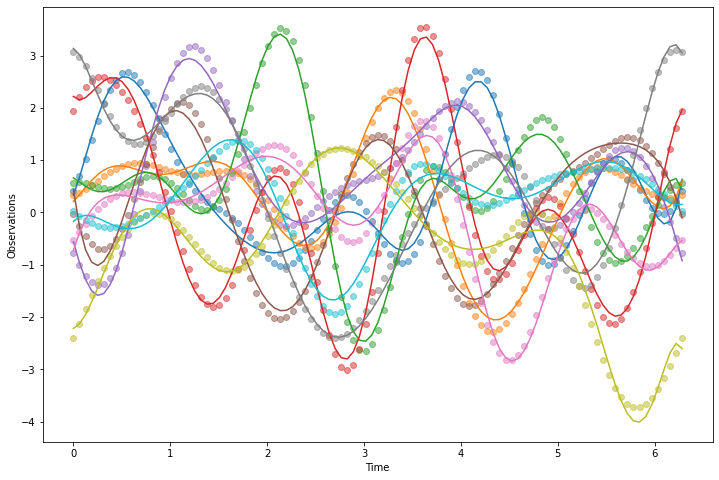

In [8]:
# how well do the GPs / splines fit the data X?
plt.figure(figsize=(12,8))
for i in range(n_samples):
    plt.scatter(obs_points_X[i].reshape(-1,1), X_mat[i], alpha=0.5)
    plt.plot(pred_points, X_fd.evaluate(pred_points).squeeze()[i])
plt.xlabel('Time')
plt.ylabel('Observations')
#plt.ylim(-10,10)
plt.show()

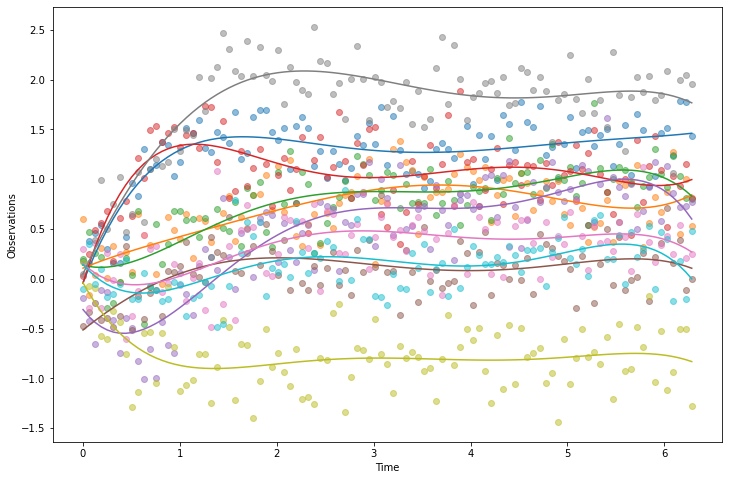

In [9]:
# how well do the GPs / splines fit the data Y?
plt.figure(figsize=(12,8))
for i in range(n_samples):
    plt.scatter(obs_points_Y[i].reshape(-1,1), Y_mat[i], alpha=0.5)
    plt.plot(pred_points, Y_fd.evaluate(pred_points).squeeze()[i])
plt.xlabel('Time')
plt.ylabel('Observations')
plt.show()

### Fitting historical functional linear model to data

In [10]:
n_intervals = 7
interval_len = upper_limit / n_intervals  # width of an element (called lambda in paper)
n_points_el = 4 # number of points per element to construct Psi
n_nodes_finel = (n_intervals+1) * (n_intervals/2 + 1)  # number of nodes for finite element method

In [11]:
n_points = n_intervals * n_points_el  # total number of points along X
lag = interval_len / (2*n_intervals)  # minimum lag to observe any influence of X in Y (can be set to 0)
lag_points = np.linspace(lag, upper_limit-lag, n_points)  # points in finite element method where influence of X in Y can be observed

In [12]:
# find which nodes are part of triangular element T in finite element method
def finel_nodes(n_intervals, lag=0):
    """
    computes indices of the three nodes defining each triangular element T
    
    Arguments:
    n_intervals: number of intervals into which the domain boundaries are divided.
    lag: difference between X and Y that is observed. By default, this is 0.
    
    Returns:
    matrix of node indices where each row entails the indices of the three nodes defining one triangular element T
    """
    n_intervals_lag = n_intervals - lag
    n_finel = n_intervals_lag**2 - (n_intervals_lag - n_intervals)**2
    finel_nodes_ = np.zeros((n_finel, 3))
    i_elem = 0
    mm3 = 0
    mm4 = 1
    
    for interval_y in range(1, n_intervals+1):
        i_elem += 1
        finel_nodes_[i_elem-1, :] = mm4+1, mm3+1, mm4+2
    
        for interval_x in range(1, interval_y):
            # left element
            i_elem += 1
            finel_nodes_[i_elem-1, :] = int(mm4+interval_x+1), int(mm3+interval_x), int(mm3+interval_x+1)
            # right element
            i_elem += 1
            finel_nodes_[i_elem-1, :] = int(mm4+interval_x+1), int(mm3+interval_x+1), int(mm4+interval_x+2)
        
        mm3 += interval_y
        mm4 += interval_y + 1
    
    return finel_nodes_

In [13]:
tri = finel_nodes(n_intervals)

In [14]:
def grid(n_intervals, upper_limit=1):
    """
    creates the grid for a parallel domain
    
    Arguments:
    n_intervals: number of intervals into which the domain boundaries are divided.
    upper_limit: upper limit of time. By default, this is 1.
    
    Returns:
    S_i: x-axis values for nodes
    T_i: y-axis values for nodes
    
    """
    interval_len = upper_limit / n_intervals
    
    S_i = [0.0]
    T_i = [0.0]
    for interval_y in range(1, n_intervals+1):
        S_i.extend(np.linspace(0, interval_y*interval_len, interval_y+1))
        T_i.extend((interval_y*interval_len) * np.ones(interval_y+1))
    
    return S_i, T_i

In [15]:
S_i, T_i = grid(n_intervals=n_intervals, upper_limit=upper_limit)
pts = np.array([S_i, T_i]).T
n_FEM_basis = pts.shape[0]

In [16]:
def create_FEM_basis(p, t):
    """
    sets up a finite element basis. The finite elements used for functional data analysis are 
    second order Lagrangian elements.  These are triangles covering a region, and the basis system is 
    piecewise quadratic.  There is a basis function associated with each node in the system. 
    Nodes are points that are vertices of triangles.
    
    Arguments:
    p: a number of vertices by 2 matrix of x-y coordinates of each vertex in the triangulation.
    t: a number of elements by 3 matrix, each row of which contains the indices of the points in p 
       that define a triangle.
    
    Returns:
    node_index:
    J_vec: Each triangle defines a linear transformation A from a fixed right master traingle with 
           vertices (0,0), (1,0) and (0,1) to itself. J contains one-half the Jacobian of this transformation, 
           which is also the area of the triangle.
    metric: the n_ele by 2 by 2 metric matrix inv(A).T @ inv(A)
    """
    n_ver = p.shape[0]    # number of vertices
    n_ele = t.shape[0]    # number of elements
    
    J_vec   = np.zeros((n_ele, 1))    # vector of Jacobian values
    metric = np.zeros((n_ele, 2, 2))    # 3-d array of metric matrices
    
    node_index = np.append(t, np.ones((len(t),1)), axis=1)
    
    for i in range(n_ele):
        # deviations of vertices 2 and 3 from vertex 1
        diff_1x = p[int(node_index[i,1])-1,0]-p[int(node_index[i,0])-1,0]
        diff_1y = p[int(node_index[i,1])-1,1]-p[int(node_index[i,0])-1,1]
        diff_2y = p[int(node_index[i,2])-1,1]-p[int(node_index[i,0])-1,1]
        diff_2x = p[int(node_index[i,2])-1,0]-p[int(node_index[i,0])-1,0]
        
        # compute the area of the triangle: a determinant halved.
        J_vec[i] = (diff_1x*diff_2y - diff_2x*diff_1y)/2
        
        # compute inverse of transformation
        
        A_el = np.array([[diff_2y, -diff_1y], [-diff_2x, diff_1x]])/J_vec[i]

        metric[i,:,:] = A_el.T @ A_el
    
    return p, node_index, J_vec, metric

In [17]:
FEM_basis = create_FEM_basis(pts, tri)

In [18]:
def tri_coef(p, t):
    """
    computes the coefficient matrix required to test if a point is indside a triangle
    Arguments:
    p: a number of vertices by 2 matrix of x-y coordinates of each vertex in the triangulation.
    t: a number of elements by 3 matrix, each row of which contains the indices of the points in p 
       that define a triangle.
    
    Returns:
    tri_coef_: coefficient matrix
    """
    n_ele = t.shape[0]    # number of elements
    # compute coefficients for computing barycentric coordinates
    tri_coef_ = np.zeros((n_ele, 4))
    tri_coef_[:,0] = p[t[:,0].astype(int)-1,0] - p[t[:,2].astype(int)-1,0]
    tri_coef_[:,1] = p[t[:,1].astype(int)-1,0] - p[t[:,2].astype(int)-1,0]
    tri_coef_[:,2] = p[t[:,0].astype(int)-1,1] - p[t[:,2].astype(int)-1,1]
    tri_coef_[:,3] = p[t[:,1].astype(int)-1,1] - p[t[:,2].astype(int)-1,1]
    
    det_T = tri_coef_[:,0]*tri_coef_[:,3] - tri_coef_[:,1]*tri_coef_[:,2]
    tri_coef__ = tri_coef_ / (det_T.reshape(-1,1) @ np.ones((1,4)))
    
    return tri_coef__

def inside_index(x, y, p, t, eps=2.2204e-12):
    """
    returns the index of the triangle containing the point (x,y) if such a triangle exists
    """    
    n_ele = t.shape[0]
    ind_ele = np.asarray(list(range(n_ele))).reshape(-1,1)
    
    # compute barycentric coordinates
    r_3 = x - p[t[:,2].astype(int)-1,0]
    s_3 = y - p[t[:,2].astype(int)-1,1]
    tri_coef_ = tri_coef(p, t)
    lam_0 = tri_coef_[:,3]*r_3 - tri_coef_[:,1]*s_3
    lam_1 = -tri_coef_[:,2]*r_3 + tri_coef_[:,0]*s_3
    lam_2 = 1 - lam_0 - lam_1

    # test these coordinates for a triple that are all between 0 and 1
    int_lam_0 = [i for i, v in enumerate(lam_0) if (v >= -eps) and (v <= 1+eps)]
    int_lam_1 = [i for i, v in enumerate(lam_1) if (v >= -eps) and (v <= 1+eps)]
    int_lam_2 = [i for i, v in enumerate(lam_2) if (v >= -eps) and (v <= 1+eps)]
    
    int_lam = list(set(int_lam_0) & set(int_lam_1) & set(int_lam_2))

    # return the index of this triple
    ind_i = ind_ele[int_lam]
    ind = np.min(ind_i)
    return ind

In [19]:
def eval_FEM_basis(x_vec, y_vec, basis_obj, t):
    """
    evaluates the FEM basis object at points in (x_vec, y_vec)
    
    Arguments:
    x_vec: a vector of x-coordinates of length n_points.
    y_vec: a vector of y-coordinates of length n_points.
    basis_obj: a functional basis object of the FEM type.
    t: a number of elements by 3 matrix, each row of which contains the indices of the points in p 
       that define a triangle.
    
    Returns:
    eval_mat: evaluation matrix of form (p.shape[1], p.shape[0]))
    """
    n_points = len(x_vec)
    
    # augment x_vec and y_vec by ones for computing barycentric coordinates 
    P_pts = np.asarray([np.ones((n_points,1)), np.array(x_vec).reshape(-1,1), y_vec.reshape(-1,1)]).squeeze().T.reshape(n_points, -1)
    nodes, node_index, J_vec, metric = basis_obj
    n_FEM_basis = nodes.shape[0]
    
    v_0 = nodes[node_index[:,0].astype(int)-1,:]
    v_1 = nodes[node_index[:,1].astype(int)-1,:]
    v_2 = nodes[node_index[:,2].astype(int)-1,:]

    # denominator of change-of-coordinates change matrix
    ones_3 = np.ones((3,1))
    J_mat = J_vec @ ones_3.T

    # 1st, 2nd, and 3rd columns of transformations to barycentric coordinates, with a row for each vertex
    M_0 = np.array([[v_1[:,0]*v_2[:,1] - v_2[:,0]*v_1[:,1]], [v_1[:,1]-v_2[:,1]], [v_2[:,0]-v_1[:,0]]]).squeeze().T/(2*J_mat)
    M_1 = np.array([[v_2[:,0]*v_0[:,1] - v_0[:,0]*v_2[:,1]], [v_2[:,1]-v_0[:,1]], [v_0[:,0]-v_2[:,0]]]).squeeze().T/(2*J_mat)
    M_2 = np.array([[v_0[:,0]*v_1[:,1] - v_1[:,0]*v_0[:,1]], [v_0[:,1]-v_1[:,1]], [v_1[:,0]-v_0[:,0]]]).squeeze().T/(2*J_mat)

    # identify triangles containing points in vector (x_vec[i], y_vec[i])
    tri_coef_ = tri_coef(nodes, t)
    ind = np.zeros(n_points)
    for i in range(n_points):
        ind[i] = inside_index(x_vec[i], y_vec[i], nodes, t)

    eval_mat = np.zeros((n_points, n_FEM_basis))
    for i in range(n_points):
        ind_i = ind[i]
        # change to barycentric coordinates
        baryc_0 = (M_0[int(ind_i),:]*P_pts[i]) @ ones_3
        baryc_1 = (M_1[int(ind_i),:]*P_pts[i]) @ ones_3
        baryc_2 = (M_2[int(ind_i),:]*P_pts[i]) @ ones_3

        eval_mat[i,int(node_index[int(ind_i),0])-1] = baryc_0
        eval_mat[i,int(node_index[int(ind_i),1])-1] = baryc_1
        eval_mat[i,int(node_index[int(ind_i),2])-1] = baryc_2
    
    return eval_mat

In [20]:
def inprod_hist(FEM_basis, fd_obj, limits, y_val, t, eps=1e-4, j_min=5, j_max=15):
    """
    computes the matrix of inner products of an FEM basis with a functional data object over a range of x-values
    for a fixed y-value. The numerical integration uses Romberg integration with the trapezoidal rule.
    
    Arguments:
    FEM_basis: an FEM basis defined by a triangulation with the p-e-t architecture within a rectangular domain.
               It is assumed that only the part of the mesh that is within the upper left triangular is of interest.
    fd_obj: a regular functional data object
    limits: limits of integration, as a list of form [lower limit, upper limit]
    y_val: the fixed y-value
    t: a number of elements by 3 matrix, each row of which contains the indices of the points in p 
       that define a triangle.
    eps: convergence criterion, defaults to 1e-4
    j_min: Minimum number of Richardson extrapolation iterations. By default, this is 5.
    j_max: Maximum number of Richardson extrapolation iterations. By default, this is 15.
    
    Returns:
    matrix of inner products for each possible pair of functions, of form (X.shape[0], FEM_basis.shape[0]).
    """
    nodes, node_index, J_vec, metric = FEM_basis
    n_FEM_basis = nodes.shape[0]
    n_samples = fd_obj.shape[0]
    
    if (y_val < np.min(limits)) or (y_val > np.max(limits)):
        raise ValueError('the y-value must be within the limits')
    
    inner_product = np.zeros((n_samples, n_FEM_basis))
    
    # loop through sub-intervals
    i = 0
    width = np.max(limits) - np.min(limits)
    j_max_p = j_max + 1
    h = np.ones((j_max_p, 1))
    h[1] = 0.25
    s = np.zeros((j_max_p, n_FEM_basis, n_samples))
    # the first iteration uses just the endpoints
    y_vec = y_val * np.ones((2,1))
    fx_0 = eval_FEM_basis(limits, y_vec, FEM_basis, t)
    fx_1 = fd_obj.evaluate(limits).T
    
    s[i,:,:] = width*(fx_0.T @ fx_1)/2
    
    # now iterate to convergence
    t_nm = 0.5
    for i in range(1, j_max):
        t_nm *= 2
        i_lag = width/t_nm
        i_limits = np.arange(limits[0]+i_lag/2, limits[1], i_lag)
        y_vec = y_val * np.ones((len(i_limits),1))
        fx_0_i = eval_FEM_basis(i_limits, y_vec, FEM_basis, t)
        fx_1_i = fd_obj.evaluate(i_limits).T
        
        chstemp = width*(fx_0_i.T @ fx_1_i)/t_nm
        chs = chstemp.reshape(1, n_FEM_basis, n_samples)
        s[i,:,:] = (s[i-1,:,:] + chs) / 2
        
        if i >= 4:
            ind = range(i-4, i+1)
            y_a = s[ind,:,:]
            x_a = h[ind]
            n_s = np.argmin(np.abs(x_a))
            y = y_a[n_s,:,:].squeeze()
            c_s = y_a
            d_s = y_a
            n_s -= 1
            for m in range(4):
                for m_i in range(5-m-1):
                    w = (c_s[m_i+1,:,:] - d_s[m_i,:,:]) / (x_a[m_i]-x_a[m_i+m+1])
                    c_s[m_i,:,:] = x_a[m_i+m+1] * w
                    d_s[m_i,:,:] = x_a[m_i] * w
                
                if 2*n_s < 5-m:
                    d_y = c_s[n_s+1,:,:].squeeze()
                else:
                    d_y = d_s[n_s,:,:].squeeze()
                    n_s -= 1
                
                y += d_y
            
            ss = y.reshape(n_FEM_basis, n_samples)
            err_val = np.max(np.abs(d_y))
            ssq_val = np.max(np.abs(ss))
            if ssq_val > 0:
                crit = err_val / ssq_val
            else:
                crit = err_val
            
            if (crit < eps) & (i > j_min):
                break
            
        s[i+1,:,:] = s[i,:,:]
        h[i+1] = 0.25 * h[i]
        if i==j_max:
            print('Failure to converge')
    
    print('# of iterations:', i)
    inner_product += ss.T
    return inner_product

In [21]:
def design_matrix(FEM_basis, fd_obj, pred_points, t, j_max=15):
    """
    computes the indefinite integrals of the curves over s up to each t-value in turn.
    
    Arguments:
    FEM_basis: an FEM basis defined by a triangulation with the p-e-t architecture within a rectangular domain.
               It is assumed that only the part of the mesh that is within the upper left triangular is of interest.
    fd_obj: a regular functional data object
    pred_points: points where fd_obj is evaluated
    t: a number of elements by 3 matrix, each row of which contains the indices of the points in p 
       that define a triangle.
    
    Returns:
    Psi_mat: design matrix Psi
    """
    nodes, node_index, J_vec, metric = FEM_basis
    n_FEM_basis = nodes.shape[0]
    n_samples = fd_obj.shape[0]
    t_pts  = pred_points[1:101]
    n_t_pts = len(t_pts)

    Psi_mat = np.zeros((n_samples*n_t_pts, n_FEM_basis))
    m_1 = 0
    
    for i_pts in tqdm(range(n_t_pts)):
        m_0 = m_1
        m_1 += n_samples
        rng_i = np.asarray([0, t_pts[i_pts]]).astype(float)
        Psi_mat[m_0:m_1, :] = inprod_hist(FEM_basis, X_fd, rng_i, t_pts[i_pts], t, j_max=j_max)
    
    return Psi_mat

In [22]:
# compute design matrix
Psi_mat = design_matrix(FEM_basis, X_fd, pred_points, tri, j_max=15)

# of iterations: 6
# of iterations: 6
# of iterations: 8
# of iterations: 7
# of iterations: 8
# of iterations: 9
# of iterations: 9
# of iterations: 9
# of iterations: 9
# of iterations: 9
# of iterations: 9
# of iterations: 9
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 9
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 10
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iterations: 11
# of iteratio

In [23]:
Y_vec = Y_fd.evaluate(pred_points[1:101]).squeeze().T.reshape(-1,1)

# solve the least squares problem
regr_coeff = scipy.linalg.lstsq(Psi_mat, Y_vec)

# compute the fit vector
Y_hat = Psi_mat @ regr_coeff[0]

# sompute two sums of squares, one for model fit and one for mean fit
SSE  = np.sum((Y_vec - Y_hat)**2)
SSE_0 = np.sum((Y_vec - np.mean(Y_hat))**2)

# express the quality of fit in terms of a squared correlation value
R_sqr = (SSE_0-SSE) / SSE_0
print(R_sqr)

0.9910470278218358


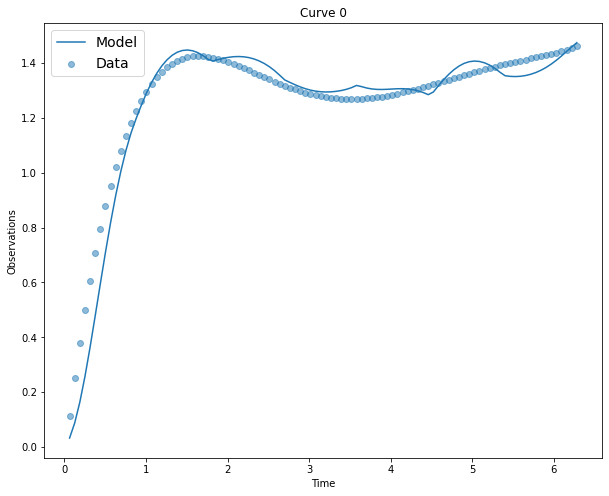

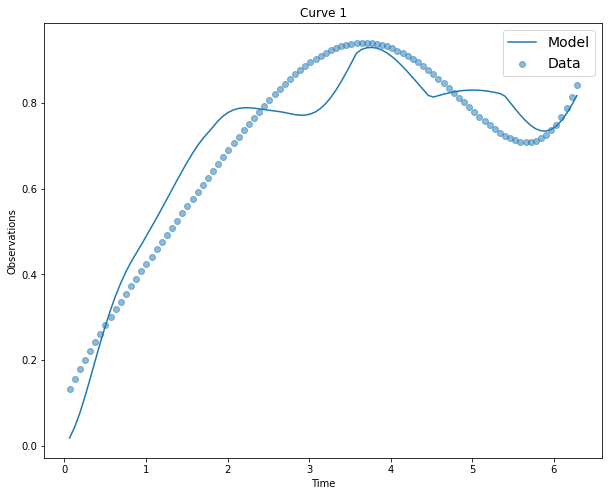

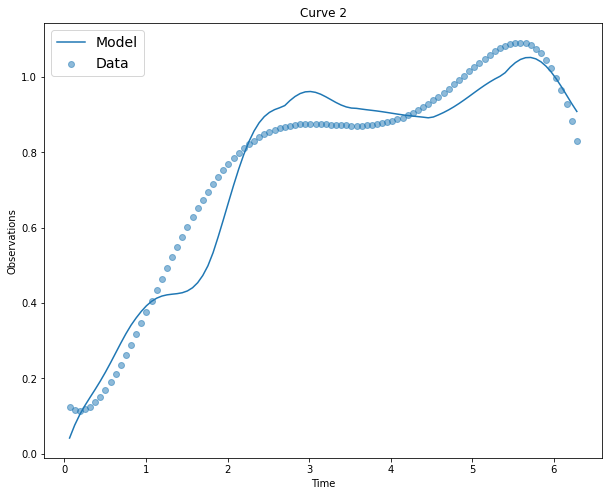

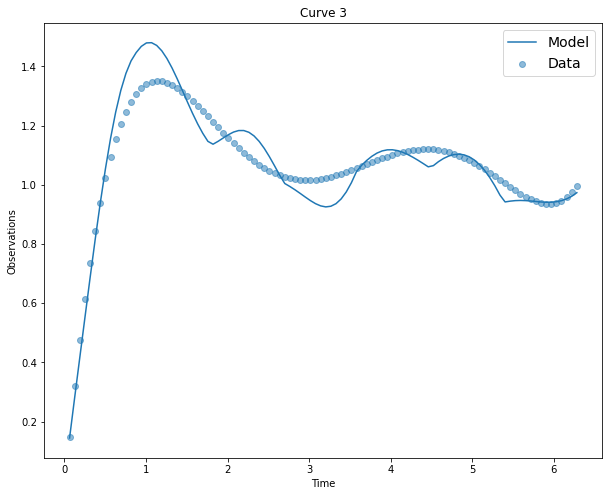

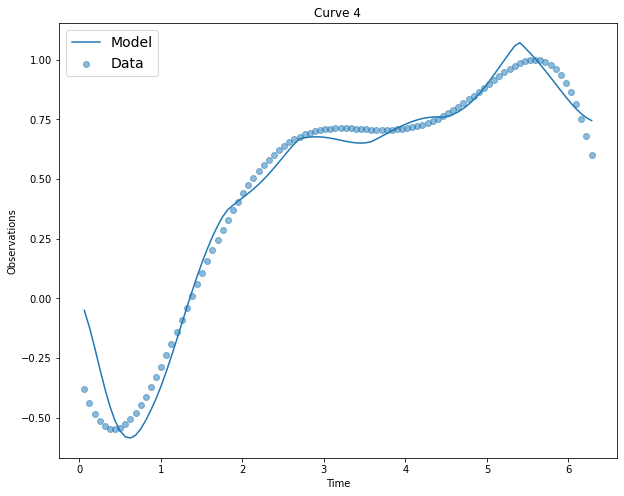

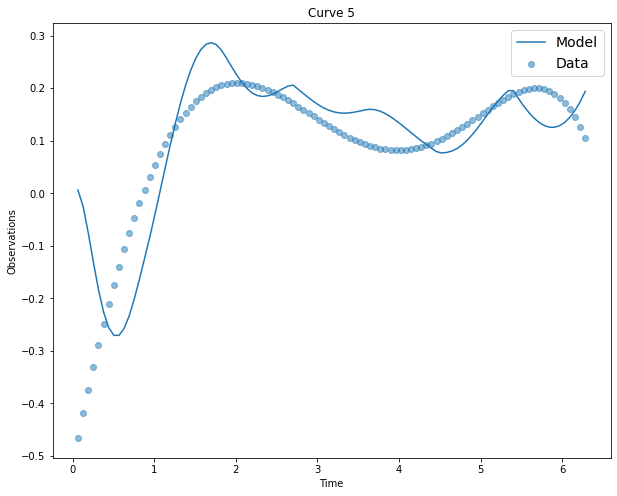

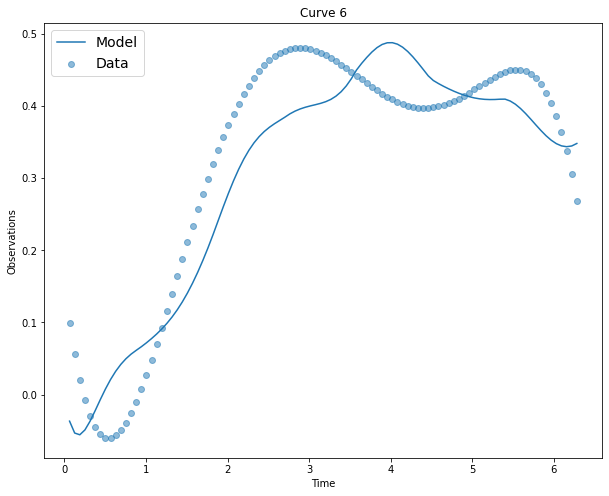

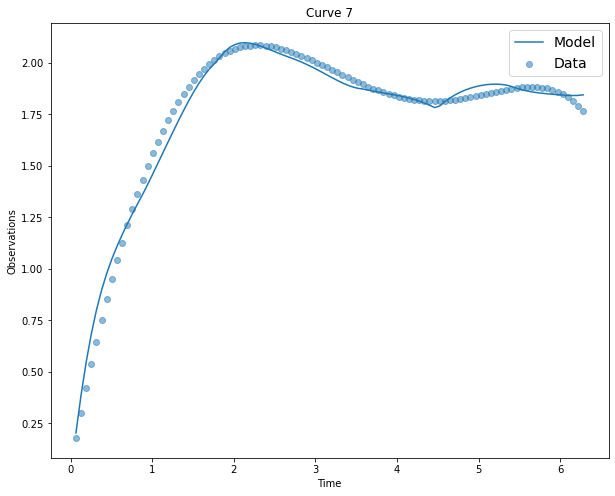

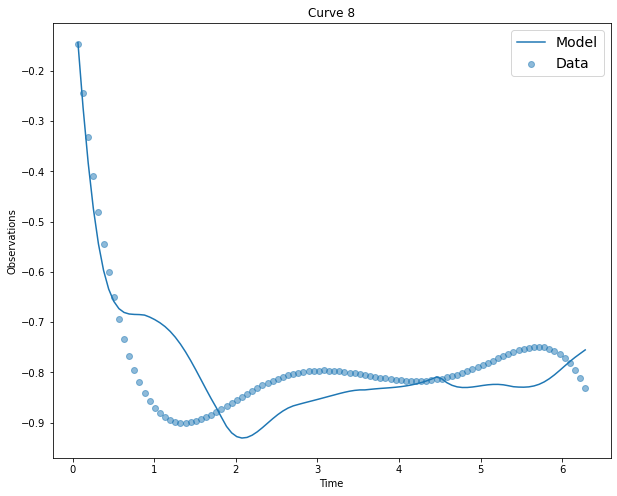

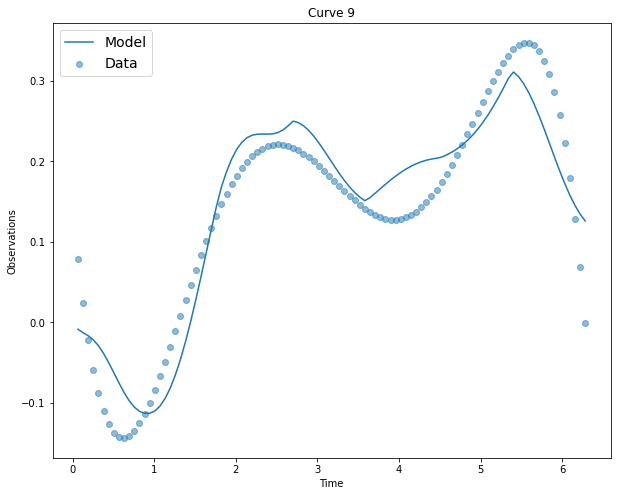

In [24]:
# plot the fits
Y_hat_mat = Y_hat.reshape(len(pred_points[1:101]), n_samples)
for i in range(n_samples):
    plt.figure(figsize=(10,8))
    plt.scatter(pred_points[1:101], Y_fd.evaluate(pred_points[1:101]).squeeze()[i], alpha=0.5, label='Data')
    plt.plot(pred_points[1:101], Y_hat_mat[:,i], label='Model')
    plt.title('Curve {}'.format(i))
    plt.xlabel('Time')
    plt.ylabel('Observations')
    plt.legend(fontsize=14)
    plt.show()